# Step 04
# Evaluation of performance

In [18]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
import utils.metrics
from config import config_vars

# Configuration

In [19]:

# Partition of the data to make predictions (test or validation)
config_vars['path_files_training'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/1-2_training.txt'
config_vars['path_files_validation'] ='/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/VALIDATION.txt'
config_vars['path_files_test'] = '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/TEST.txt'

partition = "validation"

experiment_name = 'Model_17'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 10,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/raw_images/',
 'raw_annotations_dir': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/raw_annotations/',
 'path_files_training': '/home/maloua/Malou_Master/5_Models/2_Final_Models/data/4_filelists/1-2_training.txt',
 'path_files_validation': '/home/maloua/Malou_Master/5_Models/2_Final_Models/da

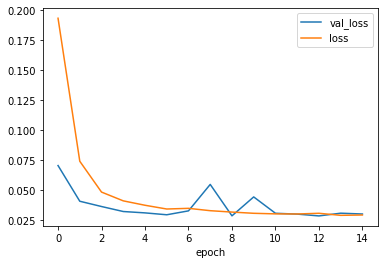

In [24]:
modellog = pd.read_csv(config_vars["csv_log_file"])
#print(modellog.dtypes)

pd.DataFrame.plot(modellog)
ax = plt.gca()
modellog.plot(x = 'epoch', y = 'val_loss', ax = ax)
modellog.plot(x = 'epoch', y = 'loss', ax = ax)

In [51]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
config_vars["object_dilation"] = 0

# Auxiliary visualization function

In [52]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

# Run the evaluation
Predictions are stored in Step 03 and loaded here for evaluation

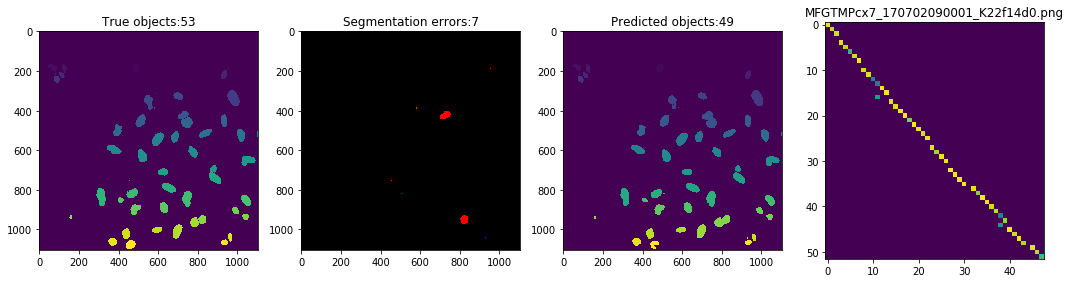

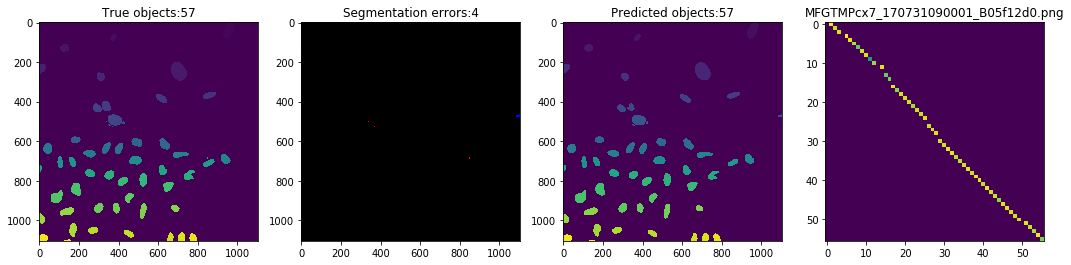

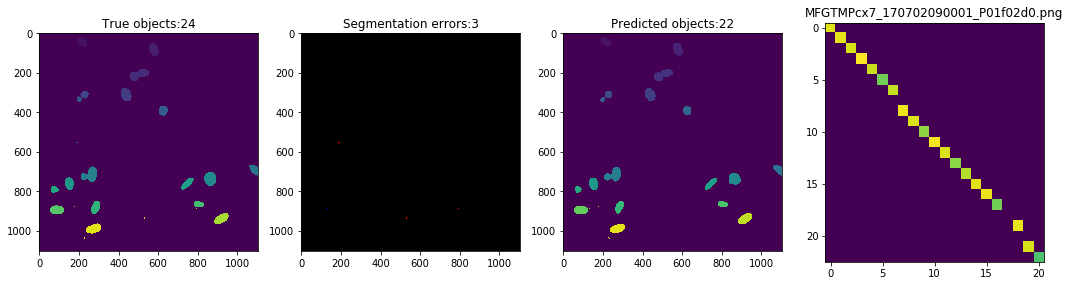

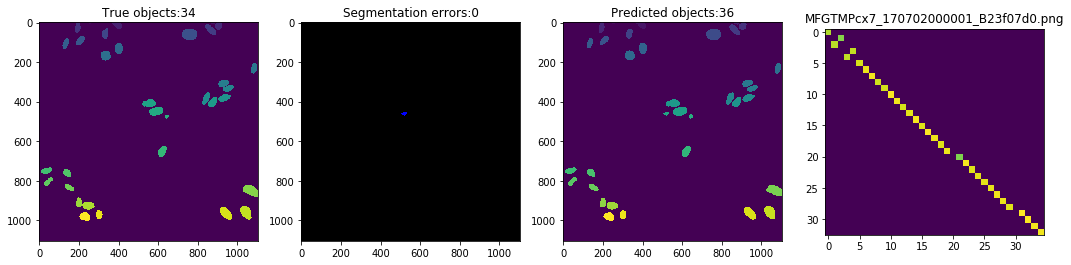

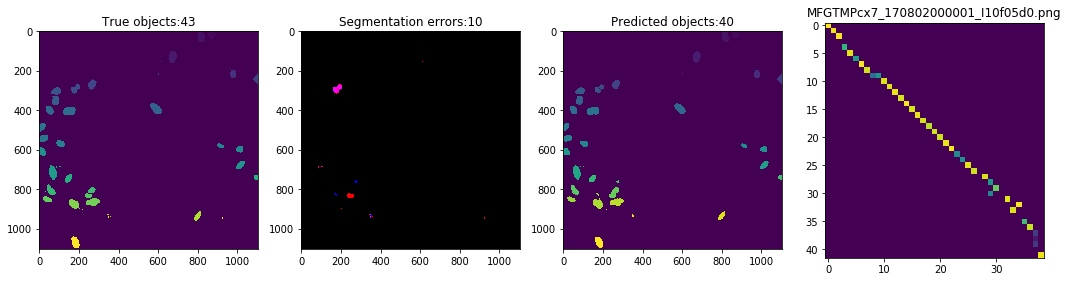

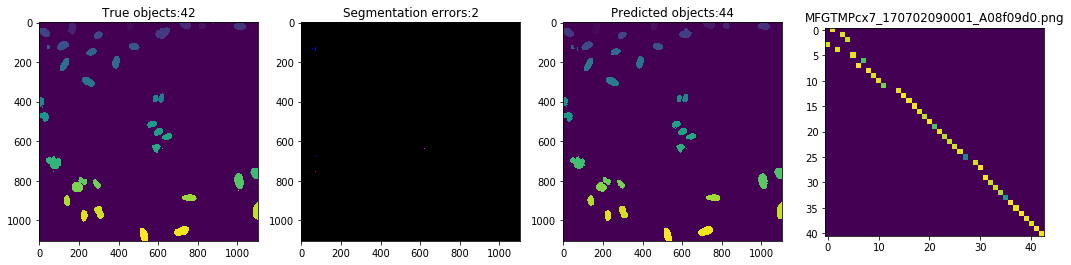

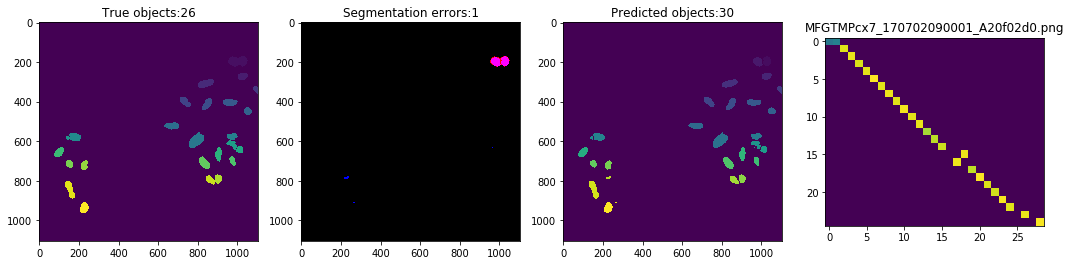

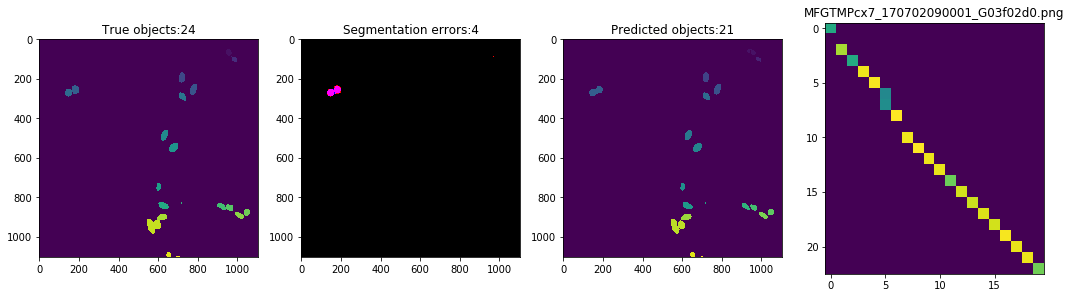

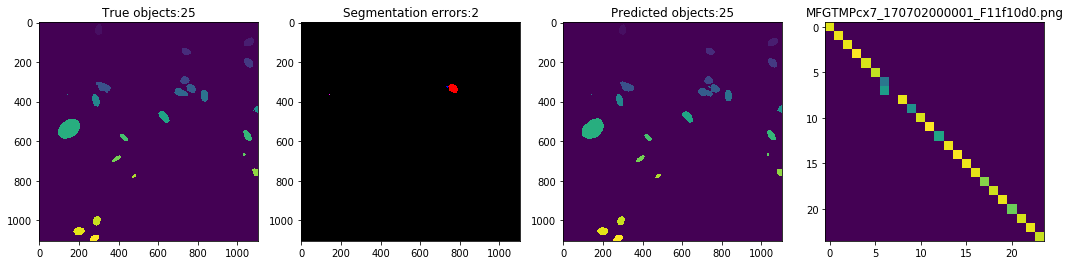

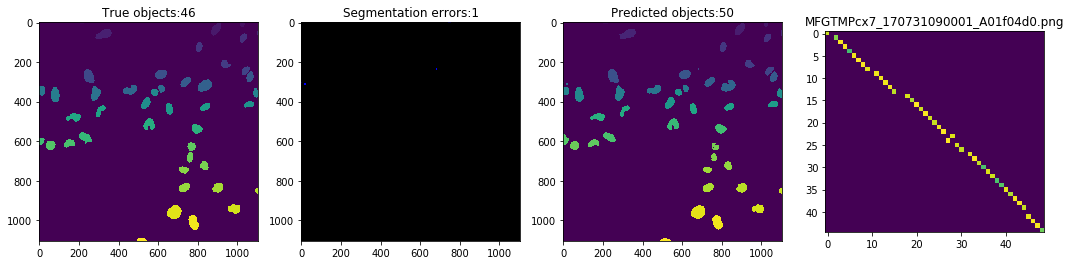

In [53]:
all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth data
    img_filename = os.path.join(config_vars["boundary_labels_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    #if len(ground_truth.shape) == 3:
    #    ground_truth = rgb2lab(ground_truth)
    #    ground_truth = ground_truth[:,:,0]
    
    ground_truth = np.argmax(ground_truth * [1, 1, 1], -1)
    
    ground_truth = utils.metrics.pred_to_label(ground_truth, config_vars["cell_min_size"])
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    #if image_name == all_images[0]:
    show(ground_truth, prediction, image_name=image_name)

# Report of results

,Image,Threshold,F1,Jaccard
0,MFGTMPcx7_170702000001_B23f07d0.png,0.725,0.858824,0.864301
2,MFGTMPcx7_170702090001_A08f09d0.png,0.725,0.795238,0.825343
3,MFGTMPcx7_170702090001_A20f02d0.png,0.725,0.770370,0.777655
8,MFGTMPcx7_170731090001_B05f12d0.png,0.725,0.751786,0.818027
7,MFGTMPcx7_170731090001_A01f04d0.png,0.725,0.751064,0.791615
6,MFGTMPcx7_170702090001_P01f02d0.png,0.725,0.740909,0.839580
5,MFGTMPcx7_170702090001_K22f14d0.png,0.725,0.726000,0.831417
1,MFGTMPcx7_170702000001_F11f10d0.png,0.725,0.720833,0.816168
4,MFGTMPcx7_170702090001_G03f02d0.png,0.725,0.679070,0.841460
9,MFGTMPcx7_170802000001_I10f05d0.png,0.725,0.595062,0.749397


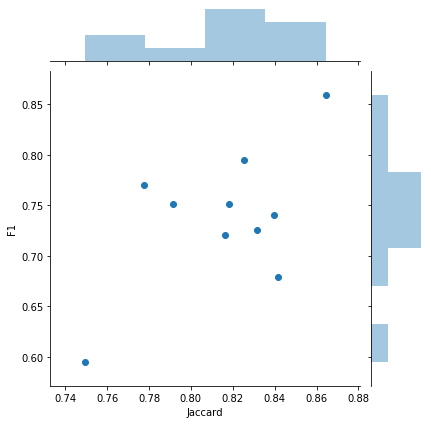

In [54]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,Threshold,F1,Jaccard
0,0.50,0.905239,0.815496
1,0.55,0.887968,0.815496
2,0.60,0.874499,0.815496
3,0.65,0.870029,0.815496
4,0.70,0.850123,0.815496
5,0.75,0.826105,0.815496
6,0.80,0.788554,0.815496
7,0.85,0.749702,0.815496
8,0.90,0.546848,0.815496
9,0.95,0.090088,0.815496


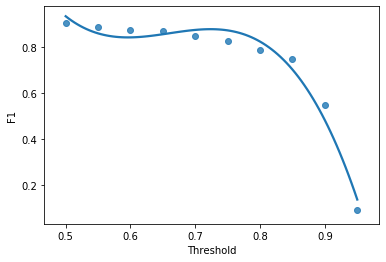

In [55]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [56]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.7389155459059205
Jaccard index: 0.8154962608407244


In [10]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,250,625,900,10000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      33
Small nuclei      3
Normal nuclei     3
Large nuclei     12
Name: False_Negative, dtype: int64

In [11]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 2
Merges: 6


In [12]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 51
